In [16]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# This is just to show you images together
def img_horizontal(images):
    plt.figure(figsize=(15,15))
    columns = 2
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

## Image Segmentation
This notebook with outline how image segmentation can be used to remove the white background of a product image. Eventually, the steps will be encapsulated in the below function `remove_white`. 

For people unfamiliar with these techniques, simply reading the code of this function may not be especially enlightening. Through the rest of this page, I will present the steps of this function in order to demonstrate **why** these methods are being used. 

By the end, you should have a good understanding of what is happening in the `remove_white` method when we use it later on.

In [17]:
def remove_white(img, thresh=250):
    src = cv2.imread(img)
    rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY) # convert RGB to grayscale

    th, im_th = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY_INV);
    white_bg = cv2.morphologyEx(im_th, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,2)))
    # black_bg = cv2.bitwise_not(white_bg) # invert mask

    im_out = cv2.bitwise_and(rgb,rgb, mask=white_bg)
    return im_out

### Starting Image

Let's start with this image of a nice green couch. The first thing we can see is the stark, white background of this image.

As people, you and I can easily see that this picture is a primarily green couch with light, wooden legs. We need to convince our computer of this fact, and my approach is to remove all of the "distracting" white from the image 

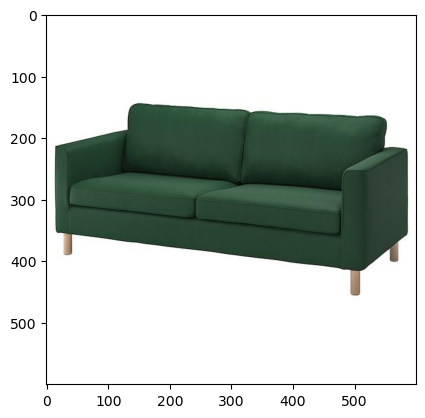

In [18]:
img_path = './green-sofa.jpg'

show_img = cv2.imread(img_path)
green_couch = cv2.cvtColor(show_img, cv2.COLOR_BGR2RGB) # correct the color coding
plt.imshow(green_couch)

### Grayscale Conversion

How does our library OpenCV actually *do* image segmentation? It looks like magic, but the technique is actually pretty simple. 

First, we will turn this color image into a fully grayscale (meaning black and white) picture. Second, we will perform "thresholding". In short, we are to divide every pixel into one of two groups based on a threshold value. 

Since our image is now grayscale, we have converted every single pixel's RGB into a single value, representing how black it is on a scale of 0-255. The threshold is the border we use to determine these groups. Any pixel above the threshold will fall into group 1, anything below into group 2.

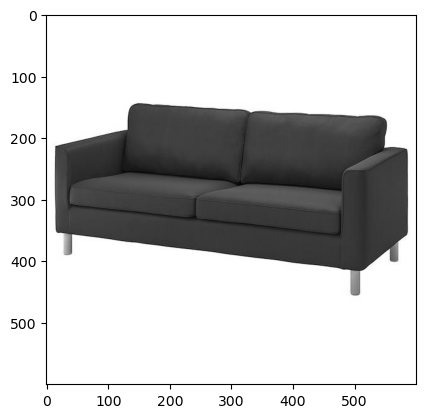

In [19]:
gray = cv2.cvtColor(show_img, cv2.COLOR_BGR2GRAY) # convert RGB to grayscale

rgb_grayscale = cv2.cvtColor(gray, cv2.COLOR_BGR2RGB) # RGB representation only to show the black and white correctly
plt.imshow(rgb_grayscale) # just to show you the grayscale couch!

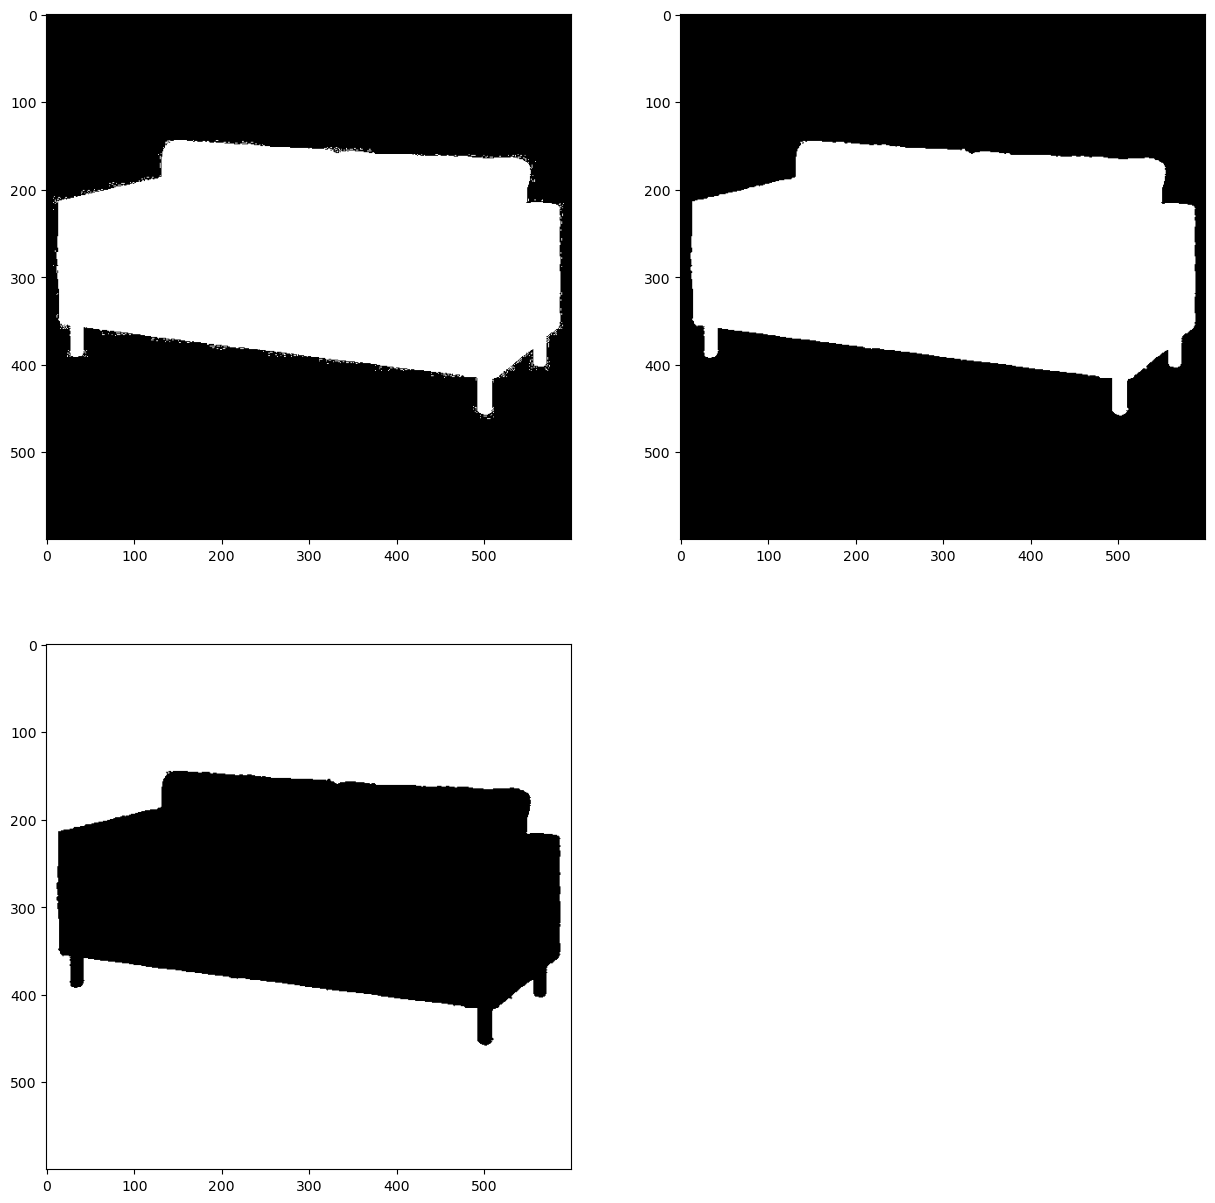

In [20]:
thresh = 250 # this is where we draw the line

h, im_th = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY_INV); # Split this grayscale image into two groups

# Use morphology to remove noise from the background
# See those tiny speckles around the first image?
black_bg = cv2.morphologyEx(im_th, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,2)))
white_bg = cv2.bitwise_not(black_bg) # invert mask


fuzzy = cv2.cvtColor(im_th, cv2.COLOR_BGR2RGB) # After thresholding
clean = cv2.cvtColor(black_bg, cv2.COLOR_BGR2RGB) # After morphology clean-up
inverted = cv2.cvtColor(white_bg, cv2.COLOR_BGR2RGB) # Switch black and white

images = [fuzzy, clean, inverted]
img_horizontal(images)

This works wonderfully. You can see that the image of the couch has been entirely "cut out" from the background. We used `morphologyEx` to clean up the edges of the cut and remove some of the random noise around the outline.

Now, we can use this outline as a template to cut out the couch the original image. The idea is that we want to be left with *only* the couch, and no background white pixels. Since there will technically be no color, the background should appear black.

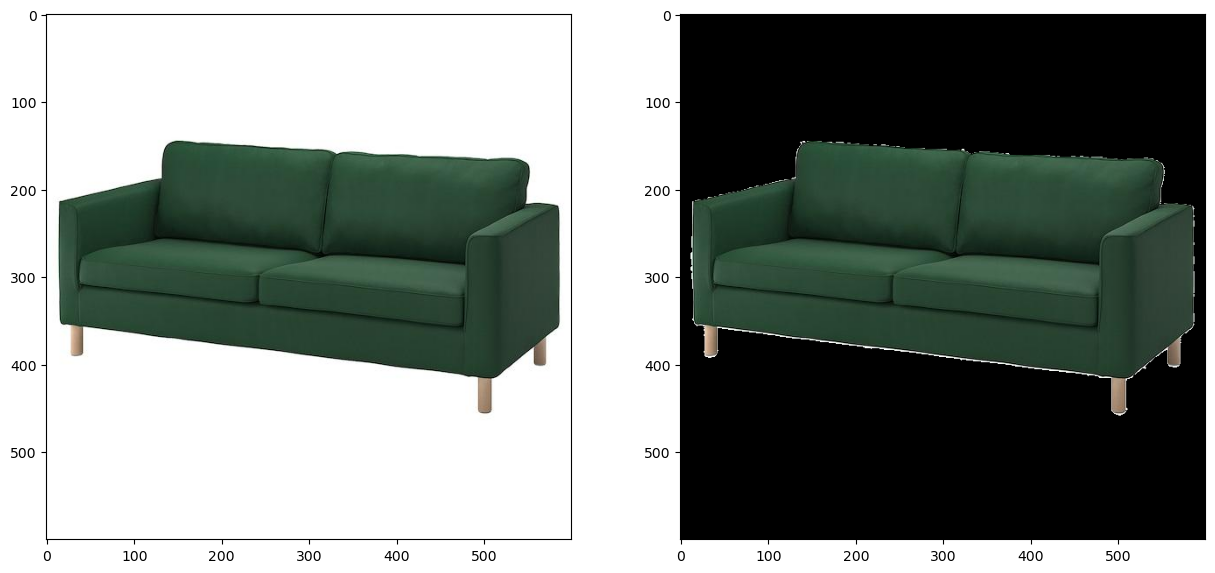

In [21]:
no_background = cv2.bitwise_and(green_couch,green_couch, mask=black_bg) # Remove all white from image

img_horizontal([green_couch, no_background])

Our magic trick is complete. By leveraging the assumption that the background is purely white, we were able to cut the couch from the background for later analysis.

Although there is a little bit of white still captured around the outline of the couch, we can proceed with this image. The amount of white from the background is so minimal, it will not have a substantial effect on the later stages.

Why is it acceptable to assume that the product image will be largely white? And what happens if the product is white as well?

The first answer is because it is a standard. Browse through your favorite online store and you will see almost every single product image will be on a perfectly white background. Once in a while you will see a "staged" image with a product in a mock environment. Imagine a picture this same green couch but in a living room. These are often called "lifestyle" product images, and we may get to those later. 

To answer the second question, I will do a demonstration. Even with a *very* white cabinet, the algorithm still works. This is because it is **exceedingly rare** for product images to have **pure white** in them. This does not happen enough to be a major concern.

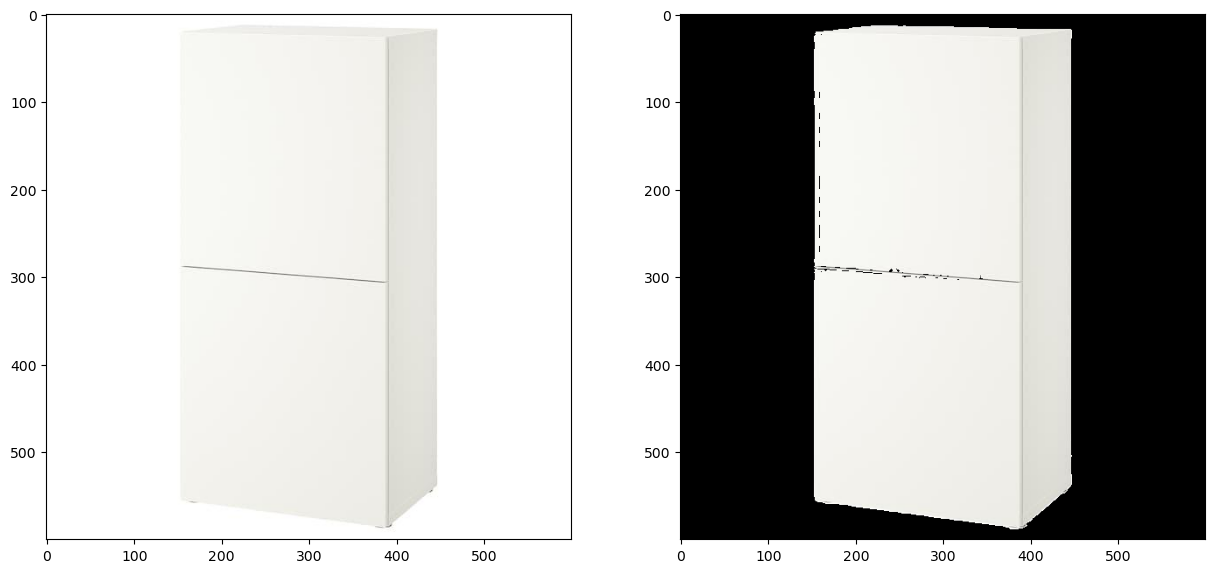

In [22]:
white_product_path = './white-cabinet.jpg'

bgr_white = cv2.imread(white_product_path)
white_product = cv2.cvtColor(bgr_white, cv2.COLOR_BGR2RGB) # correct the color coding

white_no_background = remove_white(white_product_path) # Function defined above

img_horizontal([white_product, white_no_background])

At this point we have crafted a python method to "cut" an image out from its background using image segmentation. 
To segment the image, we used OpenCV's library to:
1. Convert the image to black and white
2. Determine a **threshold** of whiteness we would define as the background
3. Use the threshold to divide every pixel of the image into one of two groups
4. Clean the fuzz from the background using `morphologyEx`
5. Use this template to "cut" the background from the original image.

We will save this image and carry it to the next stage, where we will try to determine the color palette of our green couch!

In [1]:
# Uncomment to save our segmented image!

# dest = 'green-couch-segmented.jpg'
# cv2.imwrite(dest ,no_background)